In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import TensorDataset
import numpy as np

In [5]:
X_train, y_train = next(iter(DataLoader(MNIST('./', train=True, download=True, transform=transforms.ToTensor()), batch_size=60000)))
X_test, y_test = next(iter(DataLoader(MNIST('./', train=False, download=True, transform=transforms.ToTensor()), batch_size=10000)))

In [6]:
dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)

In [7]:
train_dataloader = DataLoader(dataset_train, batch_size=128, shuffle=True)

# Implem with pytorch first

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.softmax(x)
        return x

In [7]:
model = Net()

loss_function = nn.NLLLoss(reduction="none")
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
epochs = 5

losses, accuracies = [], []

for i in range(epochs):
    pbar = tqdm(train_dataloader)
    for batch in pbar:
        X, y = batch
        model.zero_grad()
        out = model.forward(X.view(-1, 784))
        yp = torch.argmax(out, dim=1)
        accuracy = (yp == y).float().mean()
        loss = loss_function(out, y)
        loss = loss.sum()
        loss.backward()
        optim.step()

        losses.append(loss.item())
        accuracies.append(accuracy.item())
        
        pbar.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    y_test_preds = torch.argmax(model(X_test.view(-1, 784)), dim=1)
    val_acc = (y_test == y_test_preds).float().mean()
    print(f'val_acc: {val_acc}')

  0%|          | 0/469 [00:00<?, ?it/s]/home/david/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
loss 26.41 accuracy 0.92:   2%|▏         | 10/469 [00:00<00:04, 93.48it/s]

val_acc: 0.9150000214576721


loss 40.69 accuracy 0.91:   3%|▎         | 14/469 [00:00<00:03, 133.04it/s]

val_acc: 0.9298999905586243


loss 31.31 accuracy 0.91:   3%|▎         | 12/469 [00:00<00:03, 119.91it/s]

val_acc: 0.946399986743927


loss 14.28 accuracy 0.98:   3%|▎         | 12/469 [00:00<00:03, 119.73it/s]

val_acc: 0.9531999826431274


loss 14.56 accuracy 0.98: 100%|██████████| 469/469 [00:03<00:00, 121.24it/s]


val_acc: 0.9595000147819519


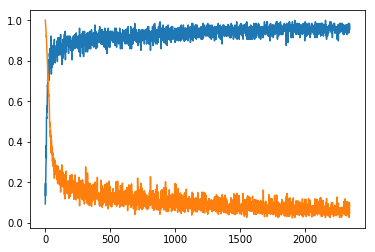

In [8]:
plt.plot(np.array(accuracies)/np.max(accuracies))
plt.plot(np.array(losses)/np.max(losses))

# With numpy

**Layers without bias**  

$
l_{1}(X)=X W_{1} \quad l_{2}(X)=X W_{2} \\  
\frac{d l(X)}{d x}=\frac{d X W}{d W}=X^{\top}
$

**ReLU function**  
$\operatorname{relu}(x)=\max (0, x)$  
$
\frac{d \operatorname{relu}(x)}{d x}=
\begin{cases} 
0 & \text{if  }  x < 0 \\
1 & \text{if  }  x > 0 \\
\end{cases}
$

**Softmax**  
$\sigma\left(x_{i}\right)=\frac{e^{x_{i}}}{\sum_{j}^{x} x_{j}}$

**Cross Entropy**  
$L\left(Y,P)=-\sum_{i=1}^{c} y_{i} \log \left(p_{i}\right)\right.$  

**Derivative of Cross Entropy w.r.t to input of softmax**  
https://peterroelants.github.io/posts/cross-entropy-softmax/    

$\frac{\partial L(Y, \sigma(l_{2}))}{\partial \sigma(l_{2})} \frac{\partial \sigma(l_{2})}{\partial l_{2}} = Y - \sigma(l_{2})$

**Derivative of Cross Entropy w.r.t $W_{1}$**  

$
\begin{align*}
\frac{d L}{d W_{1}} &=\frac{\partial L}{\partial \sigma} \frac{\partial \sigma}{\partial l_{2}} \frac{\partial l_{2}}{\partial relu} \frac{\partial relu}{\partial l_{1}} \frac{\partial l_{1}}{\partial W_{1}}\\
&=\frac{\partial L}{\partial l_{2}} \frac{\partial l_{2}}{\partial relu} \frac{\partial relu}{\partial l_{1}} \frac{\partial l_{1}}{\partial W_{1}}\\
&=\frac{\partial L}{\partial relu \left(X W_{1}\right) W_{2}} \frac{\partial relu\left(X W_{1}\right) W_{2}}{\partial relu\left(XW_{1}\right)} \frac{\partial relu\left(X W_{1}\right)}{\partial X W_{1}} \frac{\partial X W_{1}}{\partial W_{1}} \\
&=(Y - \sigma)W_{2}^{T} \begin{cases} 
0 & \text{if  }  XW_{1} < 0 \\
1 & \text{if  }  XW_{1} > 0 \\
\end{cases} X^{T}
\end{align*}
$  

**Derivative of Cross Entropy w.r.t $W_{2}$**  
$
\begin{align*}
\frac{d L}{d W_{2}} &=\frac{\partial L}{\partial l_{2}} \frac{\partial l_{2}}{\partial W_{2}}=\frac{\partial L}{\partial relu \left(X W_{1}\right) W_{2}}\frac{\partial relu \left(X W_{1}\right) W_{2}}{\partial W_{2}}=(Y - \sigma)relu \left(X W_{1}\right)^{T}
\end{align*}
$

In [4]:
import numpy as np

def relu(x):
    return np.maximum(x, 0)

def softmax(x, dim=1):
    return np.exp(x) / np.sum(np.exp(x), dim).reshape(-1, 1)

def layer_init(in_features, out_features):
    return np.random.randn(in_features, out_features) * np.sqrt(2/out_features)

## 2 layers and relu

100%|██████████| 469/469 [00:04<00:00, 114.64it/s]


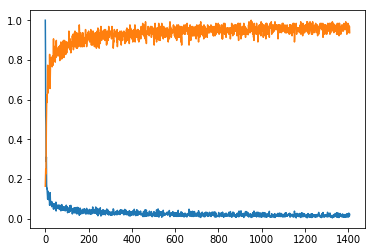

In [10]:
lr = 0.001
w1 = layer_init(784, 128)
w2 = layer_init(128, 10)

losses, accuracies = [], []

for i in range(3):
    for X, y in tqdm(train_dataloader):

        X = X.view(-1, 784).numpy()
        y = y.numpy()
        y_one_hot = np.zeros((len(y), 10), np.float32)
        y_one_hot[range(y_one_hot.shape[0]), y] = 1

        # forward
        x_l1 = X.dot(w1)
        x_relu = relu(x_l1)
        x_l2 = x_relu.dot(w2)
        x_softmax = softmax(x_l2)
        x_log_softmax = np.log(x_softmax)
        loss = - y_one_hot * x_log_softmax
        loss = loss.sum()
        accuracy = (np.argmax(x_softmax, 1) == y).astype(np.float32).mean()

        # backward
        dloss_dl2 = x_softmax - y_one_hot
        dl2_dw2 = x_relu.T
        dloss_dw2 = dl2_dw2.dot(dloss_dl2)
        
        dl2_drelu = w2.T
        drelu_dl1 = (x_l1 > 0).astype(np.float32)
        dl1_dw1 = X.T
                
        dloss_dw1 = dl1_dw1.dot(dloss_dl2.dot(dl2_drelu) * drelu_dl1)
        

        # SGD
        w1 = w1 - lr * dloss_dw1
        w2 = w2 - lr * dloss_dw2

        losses.append(loss)
        accuracies.append(accuracy)
        
plt.plot(np.array(losses)/np.max(losses))
plt.plot(np.array(accuracies)/np.max(accuracies)) 


In [11]:
x_l1 = X_test.view(-1, 784).numpy().dot(w1)
x_relu = relu(x_l1)
x_l2 = x_relu.dot(w2)
x_softmax = softmax(x_l2)
print('val acc', (np.argmax(x_softmax, 1) == y_test.numpy()).astype(np.float32).mean())

val acc 0.9578


pred 6


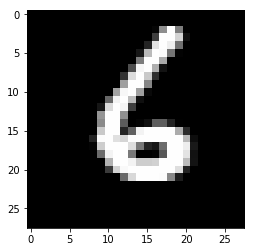

In [13]:
random_idx = np.random.choice(len(X_test))
x_sample = X_test[random_idx]
x_l1 = x_sample.view(1, 784).numpy().dot(w1)
x_relu = relu(x_l1)
x_l2 = x_relu.dot(w2)
x_softmax = softmax(x_l2)
pred = np.argmax(x_softmax)

print('pred', pred)
plt.imshow(x_sample.numpy()[0], cmap='gray')

# One layer, no relu, but using complete chain rule to calculate gradient w.r.t $W_{1}$
Calculating derivative of cross entropy w.r.t softmax
and then derivative of softmax w.r.t input

**Derivative of Cross Entropy w.r.t output of softmax**  

$
\begin{align*}
\frac{d L(Y,\sigma)}{d \sigma} &=-\frac{\partial \operatorname{sum}(Y \otimes \log (\sigma))}{\partial Y \otimes \log (\sigma)} \frac{\partial Y \otimes \log (\sigma)}{\partial \log (\sigma)} \frac{\partial \log (\sigma)}{\partial \sigma} \\
&=-\overrightarrow{1}^{T} diag(Y) \frac{1}{\sigma} \\
&=-\frac{Y^{T}}{\sigma}
\end{align*}
$  


**Derivative of Softmax w.r.t $x$**  

$
\begin{align*}
\frac{d \sigma(x)}{d x} &=\left[\begin{array}{ccc}
\sigma\left(x_{1}\right)-\sigma\left(x_{1}\right) \sigma\left(x_{1}\right) & \ldots & 0-\sigma\left(x_{1}\right) \sigma\left(x_{N}\right) \\
\ldots & \sigma\left(x_{j}\right)-\sigma\left(x_{j}\right) \sigma\left(x_{i}\right) & \\
0-\sigma\left(x_{N}\right) \sigma\left(x_{1}\right) & \ldots & \alpha\left(x_{N}\right)-\sigma\left(x_{N}\right) \sigma\left(x_{N}\right)
\end{array}\right] \\
&=\left[\begin{array}{ccc}
\sigma\left(x_{1}\right) & \cdots & 0 \\
\cdots & \sigma\left(x_{j}\right) & \cdots \\
0 & \cdots & \sigma\left(x_{N}\right)
\end{array}\right]-\left[\begin{array}{cc}
\sigma\left(x_{1}\right) \sigma\left(x_{1}\right) & \cdots & \sigma\left(x_{1}\right) \sigma\left(x_{N}\right) \\
\cdots & \sigma\left(x_{j}\right) \sigma\left(x_{i}\right) & \cdots \\
\sigma\left(x_{N}\right) \sigma\left(x_{1}\right) & \cdots & \sigma\left(x_{N}\right) \sigma\left(x_{N}\right)
\end{array}\right]
\end{align*}
$  

**Derivative of Cross Entropy w.r.t** $W_{1}$  

$
\begin{align*}
\frac{d L}{d W_{1}} &=\frac{\partial L}{\partial \sigma} \frac{\partial \sigma}{\partial l_{1}} \frac{\partial l_{1}}{\partial W_{1}}\\
&=-\frac{Y^{T}}{\sigma}\frac{\partial \sigma}{\partial l_{1}}X^T
\end{align*}
$

## gradient of softmax

In [7]:
x = np.array([[1., 2., 3.], [3., 2., 1.], [2., 3., 1.]]).astype(np.float32)
x_softmax = softmax(x, 1)

diag_softmax = np.concatenate([np.expand_dims(np.diag(vec), 0) for vec in x_softmax])
softmax_matrix = np.tile(np.expand_dims(x_softmax, 2), x_softmax.shape[1])
dsoftmax_dx = diag_softmax - softmax_matrix * np.transpose(softmax_matrix, (0, 2, 1))

In [8]:
(np.expand_dims(x, 1) @ (dsoftmax_dx)).reshape(-1, 3)

array([[-0.1418171 , -0.14077032,  0.28258747],
       [ 0.28258747, -0.14077033, -0.1418171 ],
       [-0.14077033,  0.28258747, -0.1418171 ]], dtype=float32)

In [11]:
torch_x = torch.tensor(x, requires_grad=True, dtype=torch.float32)
torch_x.retain_grad()
torch_sm = torch.softmax(torch_x, 1)
torch_sm.retain_grad()
torch_sm.backward(torch_x)

In [12]:
# pytorch actually computes X.dot(Jacobian)
torch_x.grad

tensor([[-0.1418, -0.1408,  0.2826],
        [ 0.2826, -0.1408, -0.1418],
        [-0.1408,  0.2826, -0.1418]])

In [18]:
lr = 0.001
w1 = layer_init(784, 10)

losses, accuracies = [], []

for i in range(5):
    for X, y in tqdm(train_dataloader):

        X = X.view(-1, 784).numpy()
        y = y.numpy()
        y_one_hot = np.zeros((len(y), 10), np.float32)
        y_one_hot[range(y_one_hot.shape[0]), y] = 1

        # forward
        x_l1 = X.dot(w1)
        x_softmax = softmax(x_l1)
        x_log_softmax = np.log(x_softmax)
        loss = - y_one_hot * x_log_softmax
        loss = loss.sum()
        accuracy = (np.argmax(x_softmax, 1) == y).astype(np.float32).mean()

        # backward
        dlog_dsoftmax = - y_one_hot / x_softmax
        
        diag_softmax = np.concatenate([np.expand_dims(np.diag(vec), 0) for vec in x_softmax])
        softmax_matrix = np.tile(np.expand_dims(x_softmax, 2), x_softmax.shape[1])
        dsoftmax_dl1 = diag_softmax - softmax_matrix * np.transpose(softmax_matrix, (0, 2, 1))
                
        dloss_dl1 = (np.expand_dims(dlog_dsoftmax, 1) @ (dsoftmax_dl1)).reshape(-1, 10)


        dl1_dw1 = X.T
        
        dloss_dw1 = dl1_dw1.dot(dloss_dl1)

        # SGD
        w1 = w1 - lr * dloss_dw1

        losses.append(loss)
        accuracies.append(accuracy)

100%|██████████| 469/469 [00:03<00:00, 129.19it/s]


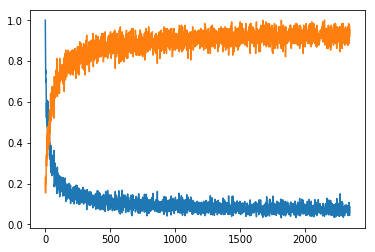

In [19]:
plt.plot(np.array(losses)/np.max(losses))
plt.plot(np.array(accuracies)/np.max(accuracies)) 